# Example notebook to showcase the usage of the Poisson VAE model

We showcase the model on a 10X ATAC sample dataset. The data can be downloaded from [here](https://www.10xgenomics.com/resources/datasets/10k-human-pbmcs-atac-v2-chromium-controller-2-standard). If you want to see how to integrate the model with a Signac analysis workflow, see the notebook `scvi_tools_example_notebook_in_R.ipynb`

## Load packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import scanpy as sc
import anndata as ad

You can install a forked version of `scvi-tools` with the Poisson VAE model from `https://github.com/lauradmartens/scvi-tools`. We will try to merge it with `scvi-tools` soon.
Run `pip install .` in the cloned repository.

In [3]:
import scvi

[rank: 0] Global seed set to 0


You will only need the `poisson_atac` package for diagnostic plots (e.g. distribution of counts). You can install the `poisson_atac` package from `https://github.com/theislab/scatac_poisson_reproducibility`.
Run `pip install .` in the cloned repository.

In [48]:
import poisson_atac as patac

In [5]:
data_path = '/lustre/groups/ml01/workspace/laura.martens/atac_poisson_data/data'

In [6]:
scvi.__version__

'0.20.1'

## Load the data

In [7]:
adata = sc.read_10x_h5(os.path.join(data_path, '10X/10k_Human_PBMCs_ATAC_v2_Chromium_Controller', '10k_pbmc_ATACv2_nextgem_Chromium_Controller_filtered_peak_bc_matrix.h5'), gex_only=False)

## Plot count distributions

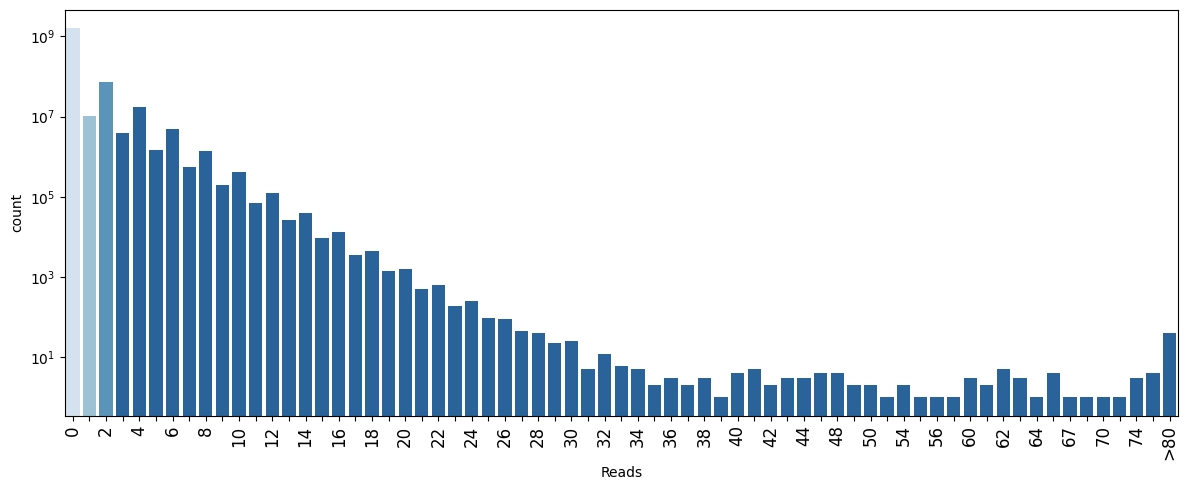

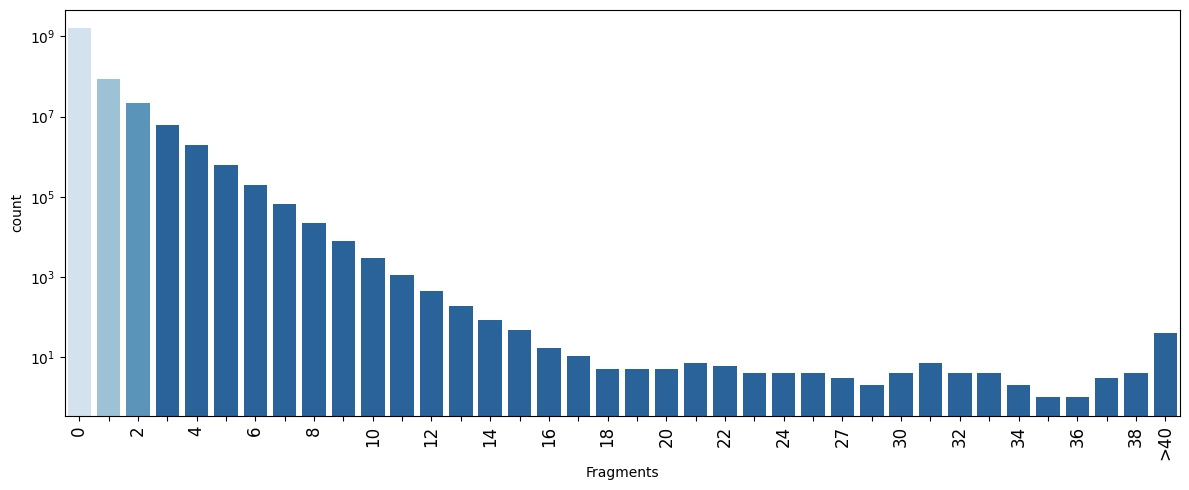

In [49]:
patac.pl.count_distribution(adata, figsize=(12, 5), limit=80)

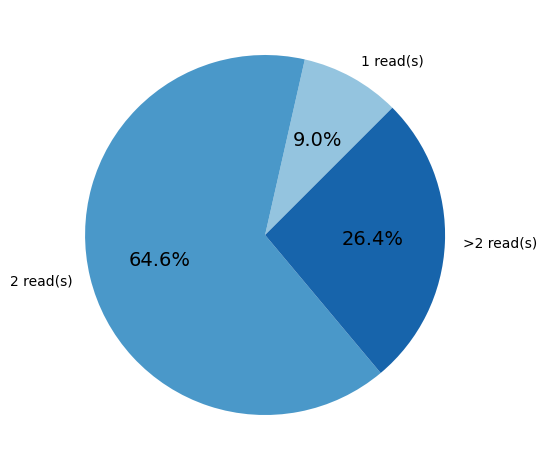

In [50]:
patac.pl.proportions(adata, lower_limit=1, upper_limit=2)

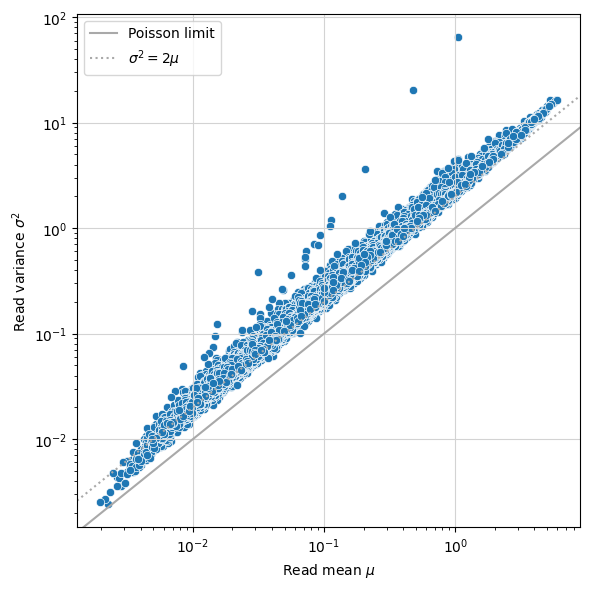

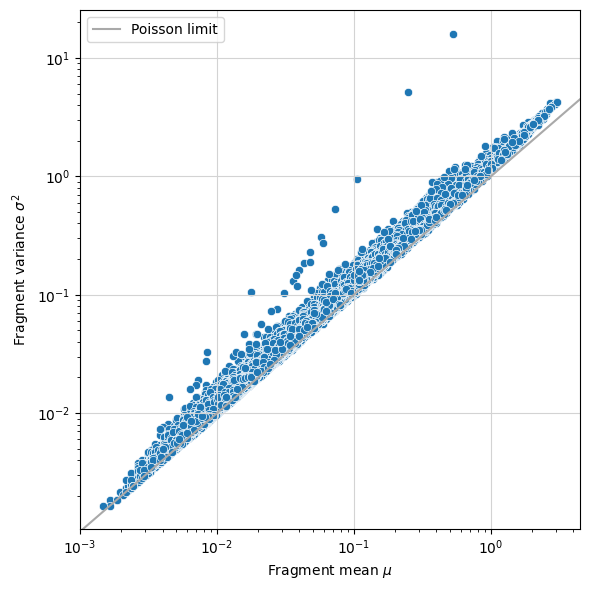

In [51]:
patac.pl.mean_variance(adata, figsize=(6,6))

## Convert to fragment counts

Stores fragment counts into a counts layer

In [8]:
scvi.model.POISSONVI.reads_to_fragments(adata)

## Setup PoissonVAE model

The model is based on the scvi models. They have a great documentation at https://scvi-tools.org/. Here you will also find more information on the parameters you can use in the setup and training of the model.

In [9]:
scvi.model.POISSONVI.setup_anndata(adata, layer="counts") # if you have batches use batch='batch_key'

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [10]:
model = scvi.model.POISSONVI(adata)

In [11]:
model

PoissonVI Model with params: 
n_hidden: 406, n_latent: 20, n_layers_encoder: 2, n_layers_decoder: 2 , dropout_rate: 0.1, latent_distribution: 
normal, deep injection: False, encode_covariates: False
Training status: Not Trained
Model's adata is minified?: False

## Train PoissonVAE model

In [14]:
model.train(train_size=0.9, validation_size=0.1)

/home/icb/laura.martens/miniconda3/envs/scvi-tools-new/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/laura.martens/miniconda3/envs/scvi-tools-n ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/laura.martens/miniconda3/envs/scvi-tools-new/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/laura.martens/miniconda3/envs/scvi-tools-n ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE

Epoch 97/500:  19%|█▉        | 97/500 [17:38<1:13:17, 10.91s/it, loss=3.43e+04, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 45 records. Best score: 34700.250. Signaling Trainer to stop.


## Save model

In [20]:
model.save('python_model.p', overwrite=True)

In [21]:
scvi.model.POISSONVI.load('python_model.p', adata=adata)

INFO     File python_model.p/model.pt already downloaded                                                           


PoissonVI Model with params: 
n_hidden: 406, n_latent: 20, n_layers_encoder: 2, n_layers_decoder: 2 , dropout_rate: 0.1, latent_distribution: 
normal, deep injection: False, encode_covariates: False
Training status: Trained
Model's adata is minified?: False

## Load model

In [22]:
model = scvi.model.POISSONVI.load('python_model.p', adata=adata)

INFO     File python_model.p/model.pt already downloaded                                                           


## Compute and plot embedding

In [15]:
# Get latent embedding of cells
X_emb = model.get_latent_representation(adata)
adata.obsm['X_emb'] = X_emb

In [16]:
sc.pp.neighbors(adata, use_rep='X_emb')
sc.tl.umap(adata)

In [17]:
sc.tl.leiden(adata)

/home/icb/laura.martens/miniconda3/envs/scvi-tools-new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


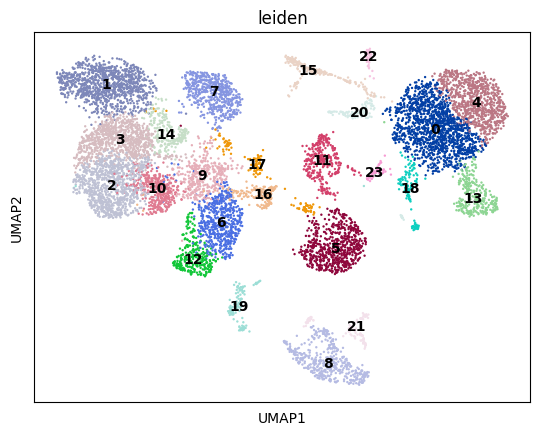

In [18]:
sc.pl.umap(adata, color="leiden", legend_loc = 'on data')

We could do further cell type annotation by looking at the gene activity of marker genes or by integrating it with scRNA-seq. To see an example how to do run the model with Signac, we refer to the notebook `scvi_tools_example_notebook_in_R.ipynb`

# Compute differentially accessible regions

We will compute differentially accessible regions per cluster, which could help us to annotate them. For this, we set two sided to `False` as we want to identify regions for which a cluster has significantly higher accessibility compared to all other clusters. 

In [23]:
da_peaks_13 = model.differential_accessibility(adata, groupby='leiden', group1='13', two_sided=False)

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/lustre/groups/ml01/code/laura.martens/scvi-tools/scvi/model/base/_differential.py:283: RuntimeWarning: divide by zero encountered in log2
  return np.log2(x + pseudocounts) - np.log2(y + pseudocounts)
/lustre/groups/ml01/code/laura.martens/scvi-tools/scvi/model/base/_differential.py:283: RuntimeWarning: invalid value encountered in subtract
  return np.log2(x + pseudocounts) - np.log2(y + pseudocounts)
/home/icb/laura.martens/miniconda3/envs/scvi-tools-new/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/icb/laura.martens/miniconda3/envs/scvi-tools-new/lib/python3.9/site-packages/numpy/core/_methods.py:213: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/home/icb/laura.martens/miniconda3/envs/scvi-tools-new/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid valu

DE...: 100%|██████████| 1/1 [02:01<00:00, 121.57s/it]


We will filter for peaks that have at least 5% of cells with non-zero counts in a cluster. This is equivalent to the `min.pct` argument of the `FindMarkers` function in Seurat.

In [24]:
da_peaks_filt = da_peaks_13[(da_peaks_13.non_zeros_proportion1 >= 0.05)]

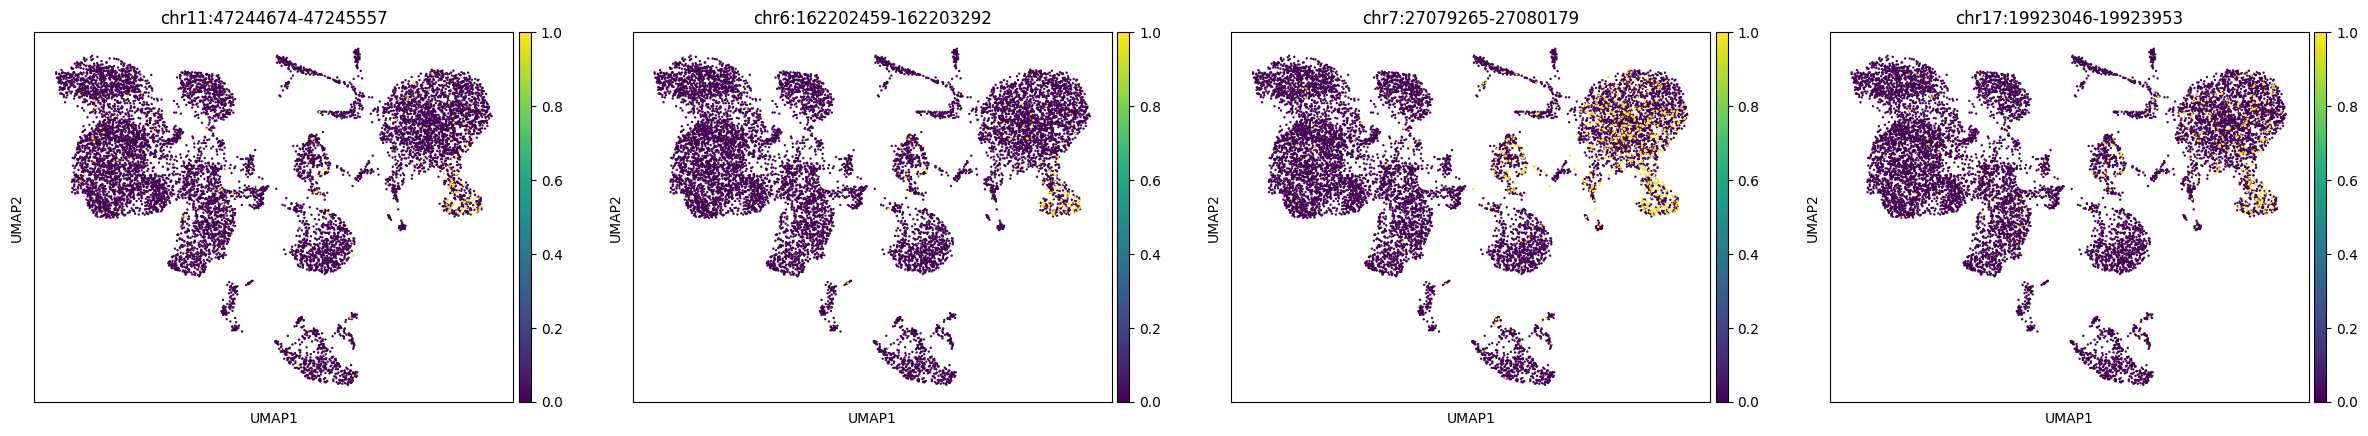

In [47]:
sc.pl.umap(adata, color=da_peaks_filt.index[:4], layer='counts', vmax='p99.0')

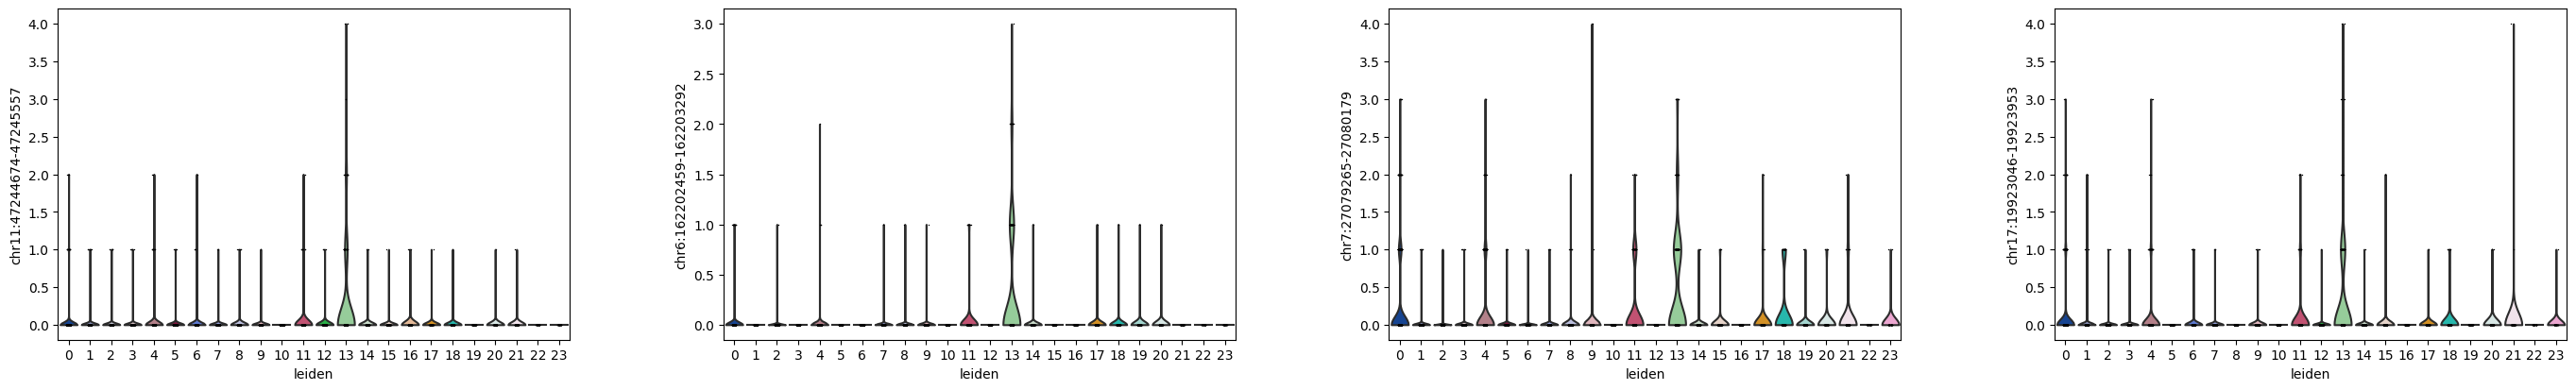

In [42]:
sc.pl.violin(adata, keys=da_peaks_filt.index[:4], groupby='leiden', layer='counts')